<a href="https://colab.research.google.com/github/rach2103/stock-market/blob/main/stock2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('tech_stock_market.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Ticker'] = df['Ticker'].str.strip()
df = df.sort_values(by=['Ticker', 'Date'])

# 2. Metadata Mapping (Ticker -> Company, Sector, Exchange)
metadata = {
    'AAPL': {'Company': 'Apple Inc.', 'Sector': 'Technology', 'Exchange': 'NASDAQ'},
    'MSFT': {'Company': 'Microsoft Corp', 'Sector': 'Technology', 'Exchange': 'NASDAQ'},
    'GOOGL': {'Company': 'Alphabet Inc.', 'Sector': 'Communication Services', 'Exchange': 'NASDAQ'},
    'AMZN': {'Company': 'Amazon.com Inc.', 'Sector': 'Consumer Cyclical', 'Exchange': 'NASDAQ'},
    'TSLA': {'Company': 'Tesla Inc.', 'Sector': 'Consumer Cyclical', 'Exchange': 'NASDAQ'},
    'ORCL': {'Company': 'Oracle Corp', 'Sector': 'Technology', 'Exchange': 'NYSE'},
    'META': {'Company': 'Meta Platforms', 'Sector': 'Communication Services', 'Exchange': 'NASDAQ'},

}


df['Company'] = df['Ticker'].map(lambda x: metadata.get(x, {}).get('Company'))
df['Sector'] = df['Ticker'].map(lambda x: metadata.get(x, {}).get('Sector'))
df['Exchange'] = df['Ticker'].map(lambda x: metadata.get(x, {}).get('Exchange', 'NASDAQ'))


df['Day_of_Week'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()
df['Quarter'] = df['Date'].dt.quarter


def process_ticker(group):
    # Volume Metrics
    group['Turnover_Value'] = group['Adj Close'] * group['Volume']
    group['Avg_Volume_30D'] = group['Volume'].rolling(30).mean()

    # Returns
    group['Daily_Return_Pct'] = group['Adj Close'].pct_change()
    group['Log_Return'] = np.log(group['Adj Close'] / group['Adj Close'].shift(1))

    # Volatility (Standard Deviation of Returns)
    group['Volatility_30D'] = group['Daily_Return_Pct'].rolling(30).std()

    # Moving Averages
    group['MA_50'] = group['Adj Close'].rolling(50).mean()
    group['MA_200'] = group['Adj Close'].rolling(200).mean()

    # RSI (Relative Strength Index)
    delta = group['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    group['RSI'] = 100 - (100 / (1 + rs))

    # MACD (Moving Average Convergence Divergence)
    exp1 = group['Adj Close'].ewm(span=12, adjust=False).mean()
    exp2 = group['Adj Close'].ewm(span=26, adjust=False).mean()
    group['MACD'] = exp1 - exp2
    group['MACD_Signal'] = group['MACD'].ewm(span=9, adjust=False).mean()

    # OBV (On-Balance Volume)
    change = np.sign(group['Close'].diff()).fillna(0)
    group['OBV'] = (change * group['Volume']).cumsum()

    return group


df_processed = df.groupby('Ticker', group_keys=False).apply(process_ticker)

sector_returns = df_processed.groupby(['Date', 'Sector'])['Daily_Return_Pct'].mean().reset_index()
sector_returns = sector_returns.rename(columns={'Daily_Return_Pct': 'Sector_Daily_Return'})
df_processed = pd.merge(df_processed, sector_returns, on=['Date', 'Sector'], how='left')

df_final = df_processed.dropna(subset=['MA_200', 'RSI', 'Volatility_30D'])
final_columns = [
    'Ticker', 'Company', 'Exchange', 'Sector', # Identity
    'Date', 'Day_of_Week', 'Month', 'Quarter', # Date
    'Open', 'High', 'Low', 'Close', 'Adj Close', # Prices
    'Volume', 'Avg_Volume_30D', 'Turnover_Value', # Volume
    'Daily_Return_Pct', 'Log_Return', 'Volatility_30D', # Returns/Risk
    'MA_50', 'MA_200', # Moving Averages
    'RSI', 'MACD', 'MACD_Signal', 'OBV', # Indicators
    'Sector_Daily_Return' # Context
]


df_final = df_final[final_columns]
df_final.to_csv('Comprehensive_Tech_Stock_Data.csv', index=False)

print("Dataset created successfully! Columns available:")
print(df_final.columns.tolist())

Dataset created successfully! Columns available:
['Ticker', 'Company', 'Exchange', 'Sector', 'Date', 'Day_of_Week', 'Month', 'Quarter', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Avg_Volume_30D', 'Turnover_Value', 'Daily_Return_Pct', 'Log_Return', 'Volatility_30D', 'MA_50', 'MA_200', 'RSI', 'MACD', 'MACD_Signal', 'OBV', 'Sector_Daily_Return']


/tmp/ipython-input-737277327.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_processed = df.groupby('Ticker', group_keys=False).apply(process_ticker)


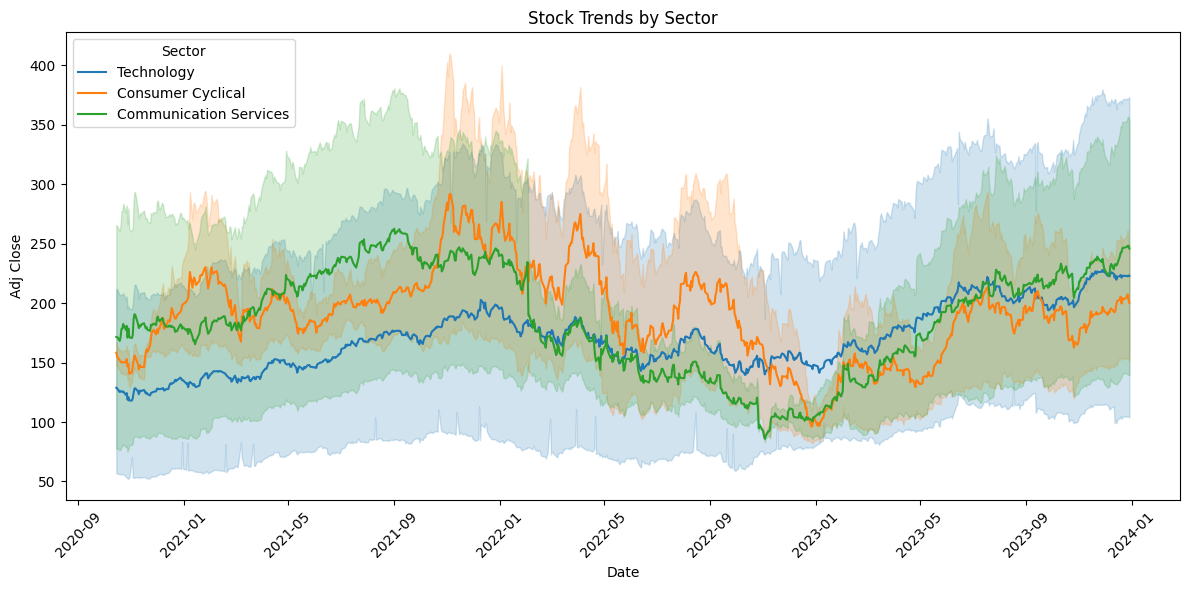

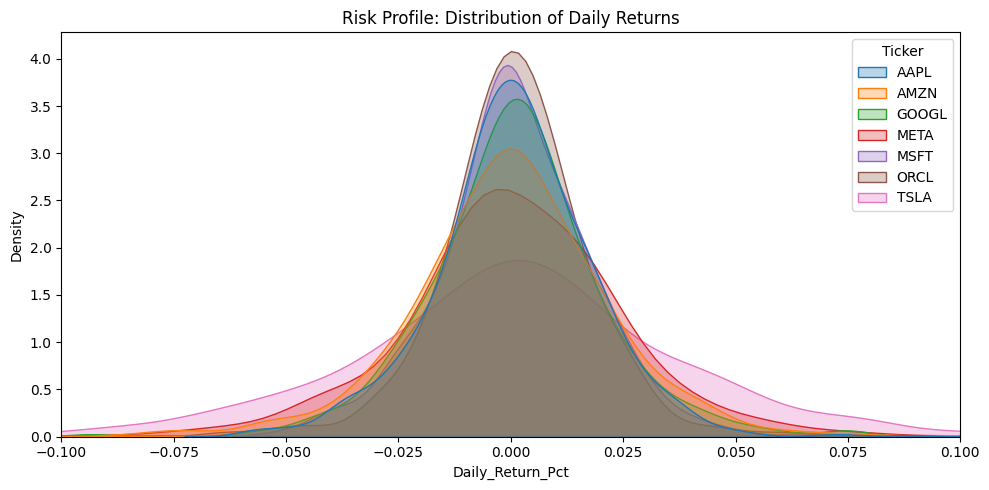

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_clean = pd.read_csv('Comprehensive_Tech_Stock_Data.csv')
df_clean['Date'] = pd.to_datetime(df_clean['Date'])


plt.figure(figsize=(12, 6))
sns.lineplot(data=df_clean, x='Date', y='Adj Close', hue='Sector')
plt.title('Stock Trends by Sector')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

sns.kdeplot(data=df_clean, x='Daily_Return_Pct', hue='Ticker', fill=True, alpha=0.3)
plt.title('Risk Profile: Distribution of Daily Returns')
plt.xlim(-0.1, 0.1)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3451839804.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.asfreq('B').fillna(method='ffill') # Handle missing weekends


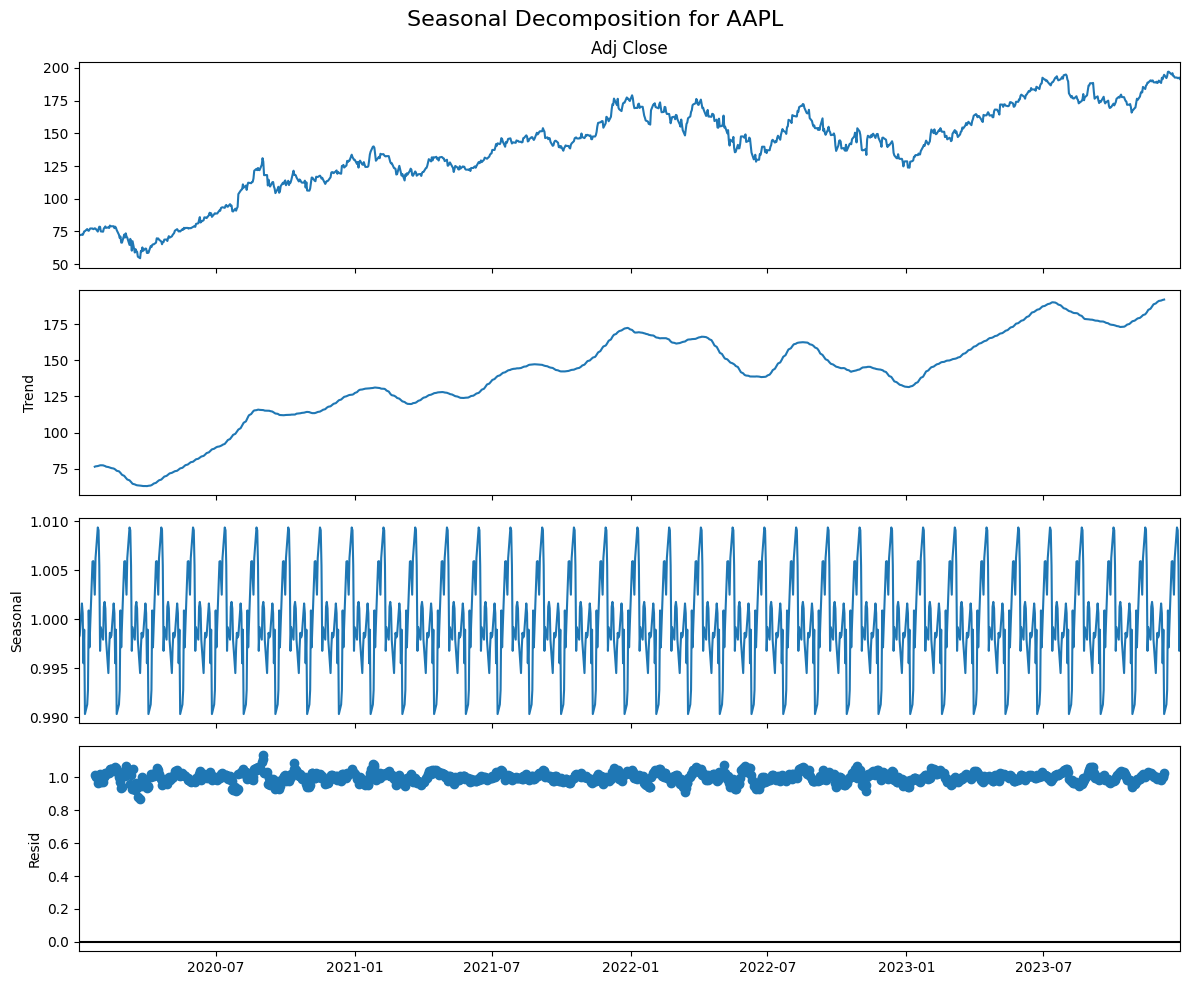

In [4]:
#EDA
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonality(df, ticker):

    data = df[df['Ticker'] == ticker].set_index('Date')['Adj Close']
    data = data.asfreq('B').fillna(method='ffill')


    result = seasonal_decompose(data, model='multiplicative', period=30)


    fig = result.plot()
    fig.set_size_inches(12, 10)
    fig.suptitle(f'Seasonal Decomposition for {ticker}', fontsize=16)
    plt.tight_layout()
    plt.show()


plot_seasonality(df, 'AAPL')


Processing analysis for AAPL...
Generating rolling forecast for ARIMA...
Best ARIMA Order: (0, 1, 0)
Optimizing Gradient Boosting parameters...
Best GB Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
--- Results for AAPL ---
ARIMA (Rolling) -> RMSE: 2.09 | MAE: 1.65 | MAPE: 0.92%
GradBoost (Tuned) -> RMSE: 3.94 | MAE: 3.31 | MAPE: 1.81%


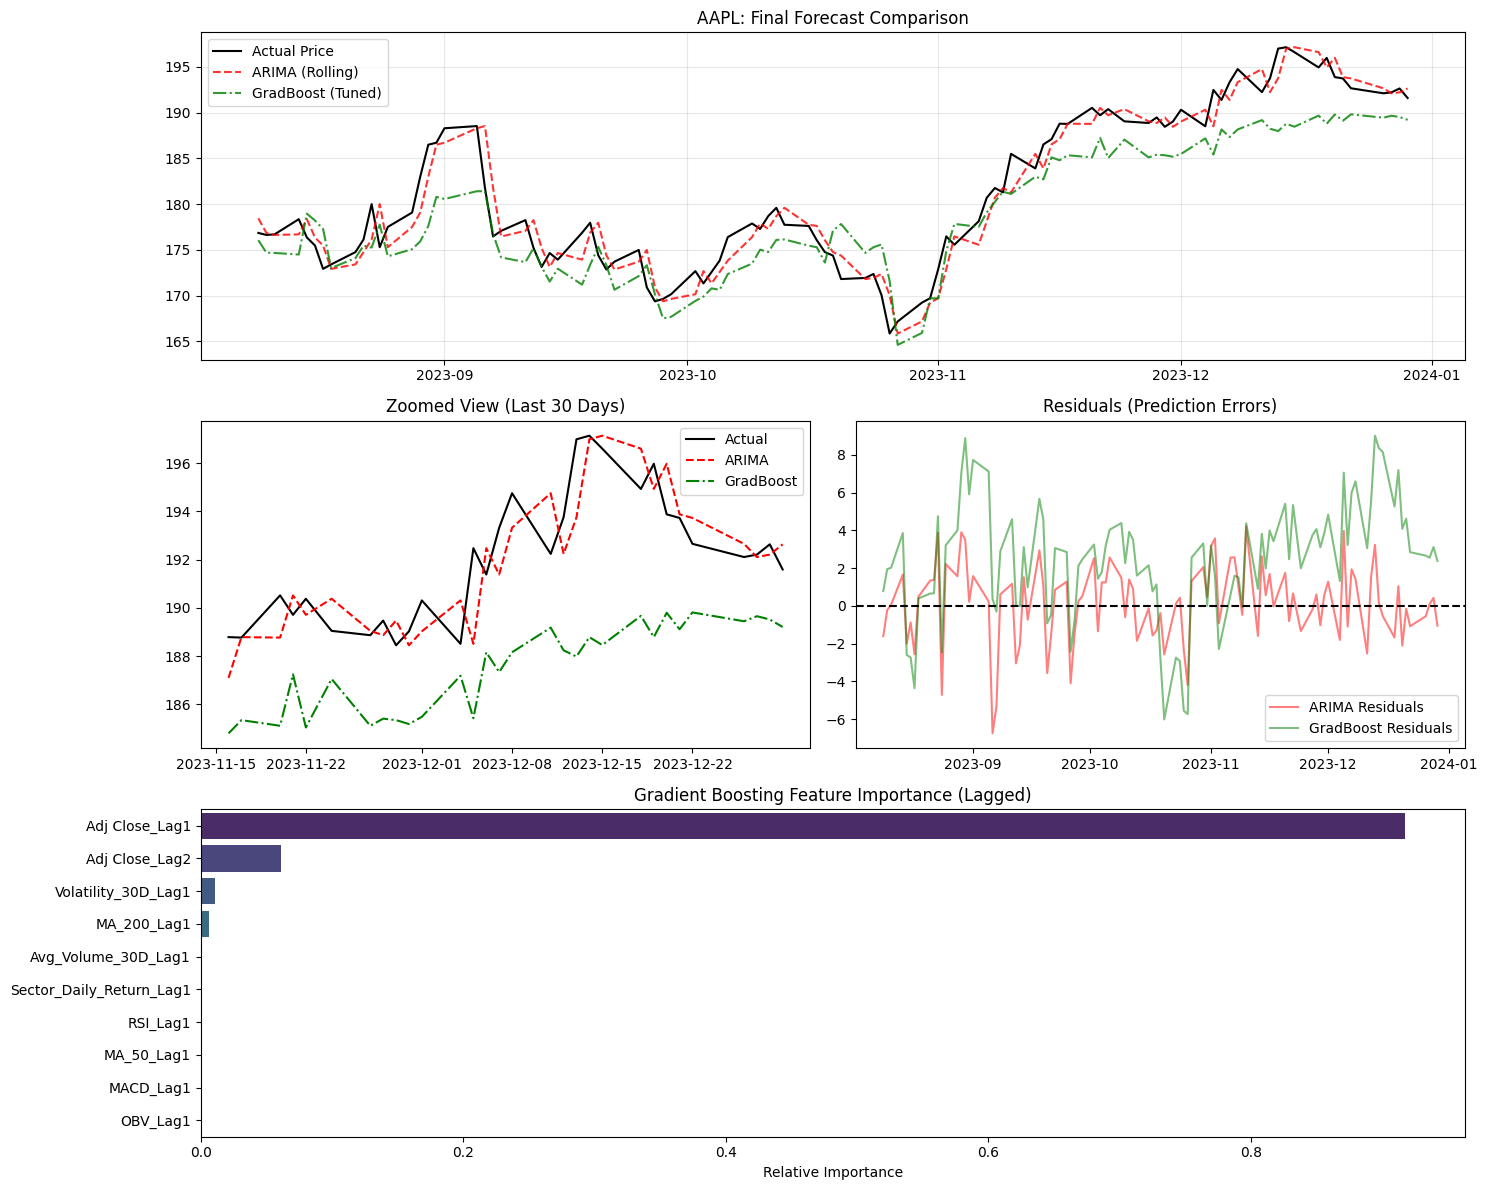

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings


warnings.filterwarnings("ignore")

# Load Data
df = pd.read_csv('Comprehensive_Tech_Stock_Data.csv')
df['Date'] = pd.to_datetime(df['Date'])

def optimize_arima(series, p_range=range(0, 4), d=1, q_range=range(0, 3)):
    """ Simple Grid Search for ARIMA """
    best_aic = float("inf")
    best_order = (1, 1, 0)

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(series, order=(p, d, q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
            except:
                continue
    print(f"Best ARIMA Order: {best_order}")
    return best_order

def optimize_gb(X_train, y_train):
    """ Grid Search for Gradient Boosting """
    print("Optimizing Gradient Boosting parameters...")

    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }

    gb_model = GradientBoostingRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)

    grid_search = GridSearchCV(
        estimator=gb_model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    print(f"Best GB Params: {grid_search.best_params_}")
    return grid_search.best_estimator_

def visualize_company_forecast(ticker, df):
    print(f"\nProcessing analysis for {ticker}...")

    #Flitering the data
    data = df[df['Ticker'] == ticker].copy()
    data = data.sort_values('Date').set_index('Date')

    # Base features present in the dataset
    base_features = ['Adj Close', 'MA_50', 'MA_200', 'RSI', 'MACD', 'OBV', 'Volatility_30D', 'Sector_Daily_Return', 'Avg_Volume_30D']
    X = data[base_features].shift(1)
    X.columns = [f"{col}_Lag1" for col in X.columns]
    X['Adj Close_Lag2'] = data['Adj Close'].shift(2)
    y = data['Adj Close']


    combined = pd.concat([X, y], axis=1).dropna()
    X = combined[X.columns]
    y = combined['Adj Close']

    # Train/Test Split (Last 100 days for testing)
    test_size = 100
    train_size = len(X) - test_size

    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


    print("Generating rolling forecast for ARIMA...")


    history = list(y_train)
    arima_predictions = []

    # Optimization
    best_order = optimize_arima(y_train)

    for i in range(len(y_test)):

        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]
        arima_predictions.append(yhat)


        history.append(y_test.iloc[i])

    forecast_arima = pd.Series(arima_predictions, index=y_test.index)

    # Gradient Boosting

    best_gb_model = optimize_gb(X_train, y_train)
    pred_gb = best_gb_model.predict(X_test)
    pred_gb_series = pd.Series(pred_gb, index=y_test.index)


    def evaluate(true, pred, model_name):
      rmse = np.sqrt(mean_squared_error(true, pred))
      mae = mean_absolute_error(true, pred)  # <--- NEW
      mape = np.mean(np.abs((true - pred) / true)) * 100
      print(f"{model_name} -> RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")

    print(f"--- Results for {ticker} ---")
    evaluate(y_test, forecast_arima, "ARIMA (Rolling)")
    evaluate(y_test, pred_gb_series, "GradBoost (Tuned)")

    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 2)

    # Main Forecast
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(y_test.index, y_test, label='Actual Price', color='black', linewidth=1.5)
    ax1.plot(y_test.index, forecast_arima, label='ARIMA (Rolling)', linestyle='--', color='red', alpha=0.8)
    ax1.plot(y_test.index, pred_gb_series, label='GradBoost (Tuned)', linestyle='-.', color='green', alpha=0.8)
    ax1.set_title(f'{ticker}: Final Forecast Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)


    ax2 = fig.add_subplot(gs[1, 0])
    n = 30
    ax2.plot(y_test.index[-n:], y_test[-n:], label='Actual', color='black')
    ax2.plot(y_test.index[-n:], forecast_arima[-n:], label='ARIMA', linestyle='--', color='red')
    ax2.plot(y_test.index[-n:], pred_gb_series[-n:], label='GradBoost', linestyle='-.', color='green')
    ax2.set_title(f'Zoomed View (Last {n} Days)')
    ax2.legend()

    # Analysis
    ax3 = fig.add_subplot(gs[1, 1])
    res_arima = y_test - forecast_arima
    res_gb = y_test - pred_gb_series
    ax3.plot(y_test.index, res_arima, label='ARIMA Residuals', color='red', alpha=0.5)
    ax3.plot(y_test.index, res_gb, label='GradBoost Residuals', color='green', alpha=0.5)
    ax3.axhline(0, color='black', linestyle='--')
    ax3.set_title('Residuals (Prediction Errors)')
    ax3.legend()

    # Featuring
    ax4 = fig.add_subplot(gs[2, :])
    importances = best_gb_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_features = [X.columns[i] for i in indices]
    sorted_importances = importances[indices]

    sns.barplot(x=sorted_importances, y=sorted_features, palette='viridis', ax=ax4)
    ax4.set_title('Gradient Boosting Feature Importance (Lagged)')
    ax4.set_xlabel('Relative Importance')

    plt.tight_layout()
    plt.savefig('Comprehensive_Forecast_Analysis.png')
    plt.show()


visualize_company_forecast('AAPL', df)